In [94]:
# Importing basic libraries for the project

import os
import zipfile
import shutil
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision

import torch.nn as nn

import torch.optim as optim

from tqdm import tqdm  # for progress bars

import torch.nn.functional as F  # Import F for functional operations





Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.62352943].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.92941177].


Device in use: cuda


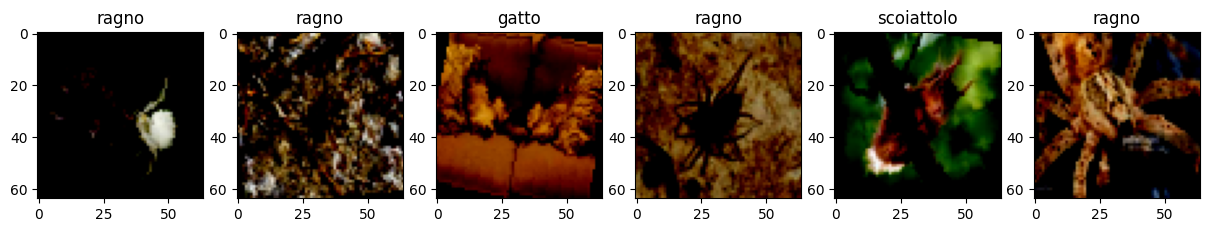

In [ ]:
# ./data/animals10"
from torchvision import transforms
from torchvision import datasets


# Use same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device in use:", device)

#define where the raw data / dataset is located
data_dir = "../data/animals10"

#transformation --resize images, convert to tensors, normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),        # Resize images
    #transforms.RandomHorizontalFlip(),  # flip some images -- Removed because the performance was 67%
    transforms.RandomRotation(15),      # small angle rotation
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize((0.5,),(0.5))  # Normalize pixel values to [-1, 1] 
])

# Load images from the folder
train_data = datasets.ImageFolder(root=data_dir, transform=transform)

# split between training and validation data
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_data, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# data loader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True) # change batch size to 16, it was too slow -- 22 sec per epoch
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# present few images
def show_images(dataset, num=6):
    fig, axes = plt.subplots(1, num, figsize=(15, 4))
    for i in range(num):
        img, label = dataset[i]
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].set_title(train_data.dataset.classes[label])
    plt.show()
show_images(train_data)


In [96]:
import torch
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())
#print(torch.cuda.get_device_name(0))


True
1


In [ ]:
# Define the CNN model
class AnimalCNN(nn.Module):
    def __init__(self):
        super(AnimalCNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)  # Input: RGB, Output: 16 feature maps

        # Second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


        # Fully connected layers
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # After pooling twice, image size is 16x16
        self.dropout = nn.Dropout(0.2)           #It was 0.5 and the accuracy dropped to 60%, I am changing to 0.2 to see if it improves
        self.fc2 = nn.Linear(128, 10)            # 10 output classes

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.conv1(x)))   # Conv1 + ReLU + Pool
        x = self.pool(nn.ReLU()(self.conv2(x)))   # Conv2 + ReLU + Pool
        x = self.pool(nn.ReLU()(self.conv3(x)))   # Conv2 + ReLU + Pool

        x = x.view(-1, 128 * 8 * 8)              
        x = nn.ReLU()(self.fc1(x))                # FC1 + ReLU
        x = self.dropout(x)                       # Apply dropout here
        x = self.fc2(x)                           # Final output layer
        return x

    
# Instantiate the model
model = AnimalCNN().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()                       # How bad is my model's prediction?

optimizer = optim.Adam(model.parameters(), lr=0.001)    # Adam optimizer # Accuracy: (0.73 & lr=0.001) - (0.18 & lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Accuracy: 0.75




AnimalCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [98]:
print("Using GPU?", torch.cuda.is_available())
print(device)
print(next(model.parameters()).device)



Using GPU? True
cuda
cuda:0


In [99]:
# Obs: 22 seconds to run 1 epoch on a GPU it was too slow, I will reduce image size from 64 to 32

import copy

# Early stopping 
best_val_loss = float('inf')    # Best validation loss seen so far
patience = 2                   # number of epochs to wait for improvement
patience_counter = 0           # Counter for patience
best_model_wts = copy.deepcopy(model.state_dict()) # Save the best model weights



# Training
num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in progress_bar:

        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #backward pass and optimize
        loss.backward()
        optimizer.step()

        #track loss and accuracy
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # this is to follow while training because the process is very slow
        progress_bar.set_postfix({
            "Loss": f"{running_loss / (total / images.size(0)):.4f}",
            "Acc": f"{100 * correct / total:.2f}%"
        })

    # Calculate validation    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)
    train_acc = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(val_loss) 

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {train_acc:.2f}%")

    # Early Stopping Logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_wts = copy.deepcopy(model.state_dict())  # Save weights
        # Ensure the 'models' directory exists
        os.makedirs('../models', exist_ok=True)
        # Save best model weights to disk
        torch.save(model.state_dict(), '../models/best_model.pth')
        print("🔍 Validation loss improved — saving best model.")
    else:
        patience_counter += 1
        print(f"⏳ No improvement in val loss. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("🛑 Early stopping triggered!")
            break


print("✅ Training completed!")



Epoch 1/10: 100%|██████████| 655/655 [00:26<00:00, 24.26batch/s, Loss=1.0655, Acc=18.30%]


Epoch [1/10], Train Loss: 2.2712, Val Loss: 2.2139, Accuracy: 18.30%
🔍 Validation loss improved — saving best model.


Epoch 2/10: 100%|██████████| 655/655 [00:27<00:00, 24.24batch/s, Loss=1.0359, Acc=19.03%]


Epoch [2/10], Train Loss: 2.2082, Val Loss: 2.2133, Accuracy: 19.03%
🔍 Validation loss improved — saving best model.


Epoch 3/10: 100%|██████████| 655/655 [00:27<00:00, 24.20batch/s, Loss=1.0356, Acc=18.83%]


Epoch [3/10], Train Loss: 2.2075, Val Loss: 2.2134, Accuracy: 18.83%
⏳ No improvement in val loss. Patience: 1/2


Epoch 4/10: 100%|██████████| 655/655 [00:26<00:00, 24.85batch/s, Loss=1.0355, Acc=18.59%]


Epoch [4/10], Train Loss: 2.2073, Val Loss: 2.2166, Accuracy: 18.59%
⏳ No improvement in val loss. Patience: 2/2
🛑 Early stopping triggered!
✅ Training completed!
